https://www.tensorflow.org/tutorials/keras/regression

Arbol de decisión de nuestro algoritmo de Maching Learning
<img src="ml_map.png">

## Importamos los datos

In [1]:
import pandas as pd
import mord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# read the clean data
df = pd.read_csv('all_data_clean_ordinal_oversampled_group.csv')
print(df.shape)

var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x = var_x_num + ['Sector_ordinal']
var_y = ['Rating_group_ordinal']
df = df[var_y + var_x]

df_model = df[df['Rating_group_ordinal'] != 7] # quitamos el raintg C que es el grupo 7
del df
df_model


(61608, 28)


,Excel Company ID,Rating,Sector,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,...,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio,Rating_group,Net Debt,Sector_ordinal,Rating_ordinal_group,Rating_group_ordinal
0,IQ12465523,AAA,Industrials,354.265394,16.225136,166.531611,2688.196468,700.567531,479.487610,896.264571,...,0.505683,0.260870,0.023160,0.819365,2.999334,AAA,880.039435,3,0,0
1,IQ139677,AAA,Health Care,51738.595800,12060.237300,13136.292300,175329.594600,52213.931400,25157.230200,38122.289400,...,0.990896,0.482563,0.230977,0.530467,4.599136,AAA,26062.052100,6,0,0
2,IQ2334713,AAA,Financials,1741.056656,0.000000,1644.750919,271884.943246,47716.660129,0.000000,45723.823768,...,0.036487,0.034469,0.000000,0.203971,5.946242,AAA,45723.823768,7,0,0
3,IQ5522615,AAA,Industrials,340.801900,248.834380,81.880680,1327.015840,464.413790,452.977970,607.468850,...,0.733832,0.712113,0.535803,1.726263,2.184500,AAA,358.634470,3,0,0
4,IQ127144955,AAA,Industrials,122.634157,41.677696,30.738172,1080.882729,123.530024,134.379961,154.755945,...,0.992748,0.586221,0.337389,0.301907,6.984434,AAA,113.078249,3,0,0


## Modelos
### Modelo de clasificación lineal con una variable

In [5]:
# Ejemplo de datos
var = 'Net Debt to EBITDA'

In [6]:
# usamos la funcion cut para definir los intervalos de las variables continuas
df_model[var+'_group'] = pd.cut(df_model[var], bins=7)

# Crear una tabla de frecuencia bidimensional
table_frecuencia = pd.crosstab(df_model['Rating_group_ordinal'], df_model[var+'_group'], normalize='index')*100
# round the table to 0 decimal places
table_frecuencia = table_frecuencia.round(0)
table_frecuencia

C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\4155509607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[var+'_group'] = pd.cut(df_model[var], bins=7)


Net Debt to EBITDA_group,"(-0.0139, 1.99]","(1.99, 3.98]","(3.98, 5.97]","(5.97, 7.96]","(7.96, 9.95]","(9.95, 11.94]","(11.94, 13.93]"
Rating_group_ordinal,,,,,,,
0,62.0,19.0,14.0,2.0,0.0,2.0,2.0
1,33.0,22.0,20.0,12.0,8.0,4.0,2.0
2,32.0,30.0,23.0,8.0,4.0,2.0,1.0
3,31.0,36.0,19.0,9.0,3.0,1.0,1.0
4,32.0,40.0,18.0,6.0,2.0,1.0,1.0
5,20.0,32.0,24.0,13.0,6.0,3.0,2.0
6,24.0,31.0,21.0,10.0,8.0,4.0,1.0


In [7]:
# make the average of 'Debt to Assets' by Rating_group_ordinal
table_mean = df_model.groupby('Rating_group_ordinal')[var].mean().reset_index()
table_mean

,Rating_group_ordinal,Net Debt to EBITDA
0,0,2.424259
1,1,4.141263
2,2,3.568154
3,3,3.462636
4,4,3.185627
5,5,4.335870
6,6,4.203050


In [8]:
def clasificar_valor(valor, lista_medias):
    # Calcula la diferencia absoluta entre el valor y cada media de la lista
    diferencias = [abs(valor - media) for media in lista_medias]
    # Encuentra el índice de la menor diferencia
    indice_min_diferencia = diferencias.index(min(diferencias))
    # Retorna la media más cercana usando el índice encontrado
    return indice_min_diferencia


In [9]:
# Ejemplo de uso
lista_medias =list(table_mean[var])
nuevo_valor = 0.1  # El nuevo valor a clasificar

media_mas_cercana = clasificar_valor(nuevo_valor, lista_medias)
print(f"La media más cercana a {nuevo_valor} es {media_mas_cercana}.")


La media más cercana a 0.1 es 0.


In [10]:
y_pred = [clasificar_valor(valor, lista_medias) for valor in df_model[var]]
y_true = df_model['Rating_group_ordinal']

In [11]:
mse = mean_squared_error(y_true, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

Error Cuadrático Medio (MSE): 8.722262414899735


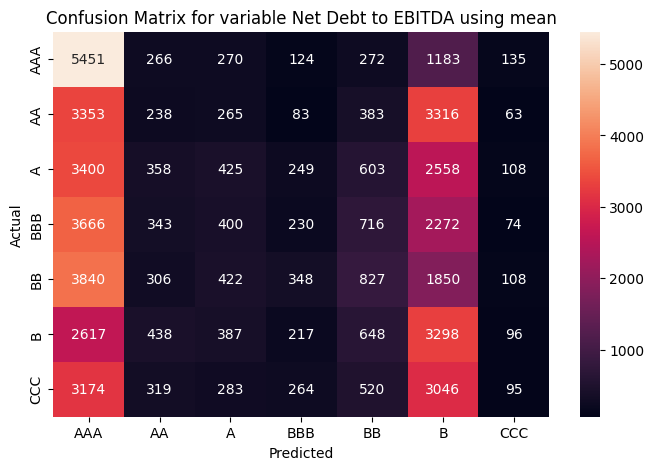

In [12]:
# plot the confusion matrix
All_rating_order_group = ['AAA','AA','A','BBB','BB','B','CCC']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
plt.xticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)
plt.yticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)
plt.title('Confusion Matrix for variable '+var+' using mean')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Podemos ver como no clasifica bein las empresas. Ahora vemos si hacemos esto mismo para todas las varaibles y a ver si alguna funciona mejor

### Modelo de clasificación lineal con una variable para todas las vaiables

In [13]:
print(var_x)
df_model[var_x]

['Net Debt to EBITDA', 'Debt to Assets', 'Current Ratio', 'Quick Ratio', 'Cash ratio', 'Long Term Debt to Equity', 'Debt to Equity', 'Debt ratio', 'Financial Leverage', 'Sector_ordinal']


,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,3
1,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,6
2,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,7
3,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,3
4,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,3
...,...,...,...,...,...,...,...,...,...,...
53902,0.814066,0.428193,1.668137,1.182205,0.580163,0.525848,0.748843,2.853482,2.136809,1
53903,2.110658,0.478092,0.949762,0.941875,0.650448,0.826536,0.916046,2.503983,2.293764,3
53904,4.929733,0.425980,1.519325,0.905881,0.267209,0.702506,0.742099,2.882532,2.139124,1
53905,8.452607,0.420066,1.288832,0.749679,0.438383,0.614159,0.724333,2.614302,1.893625,1


In [14]:
for var in var_x:
    # compute the median of the column va by Rating_group_ordinal
    table_median = df_model.groupby('Rating_group_ordinal')[var].median()
    #table_mean = df_model.groupby('Rating_group_ordinal')[var].mean()
    
    list_clasifier =list(table_median.values)
    df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]
    print('Done',var)

C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Net Debt to EBITDA


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Debt to Assets


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Current Ratio


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Quick Ratio


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Cash ratio


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Long Term Debt to Equity


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Debt to Equity


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Debt ratio


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


Done Financial Leverage
Done Sector_ordinal


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\3686621827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,var+'_predicted'] =  [clasificar_valor(valor, list_clasifier) for valor in df_model[var]]


In [15]:
# make the average and round to 0 deciclames of all the columns that are named _predicted
df_model.loc[:,'Predicted'] = df_model[[col for col in df_model.columns if '_predicted' in col]].mean(axis=1).round(0)
df_model

C:\Users\Ruben\AppData\Local\Temp\ipykernel_9268\320775653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,'Predicted'] = df_model[[col for col in df_model.columns if '_predicted' in col]].mean(axis=1).round(0)


,Rating_group_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,...,Debt to Assets_predicted,Current Ratio_predicted,Quick Ratio_predicted,Cash ratio_predicted,Long Term Debt to Equity_predicted,Debt to Equity_predicted,Debt ratio_predicted,Financial Leverage_predicted,Sector_ordinal_predicted,Predicted
0,0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,...,2,1,0,0,0,2,3,0,0,1.0
1,0,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,...,0,1,0,6,0,0,0,0,1,1.0
2,0,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,...,0,1,0,0,0,0,0,1,1,0.0
3,0,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,...,5,1,6,4,5,5,5,5,0,4.0
4,0,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,...,0,1,1,4,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53902,6,0.814066,0.428193,1.668137,1.182205,0.580163,0.525848,0.748843,2.853482,2.136809,...,2,5,4,4,1,2,4,1,0,2.0
53903,6,2.110658,0.478092,0.949762,0.941875,0.650448,0.826536,0.916046,2.503983,2.293764,...,3,1,4,4,4,3,5,1,0,2.0
53904,6,4.929733,0.425980,1.519325,0.905881,0.267209,0.702506,0.742099,2.882532,2.139124,...,2,5,4,4,3,2,4,1,0,3.0
53905,6,8.452607,0.420066,1.288832,0.749679,0.438383,0.614159,0.724333,2.614302,1.893625,...,1,6,5,4,2,1,6,1,0,3.0


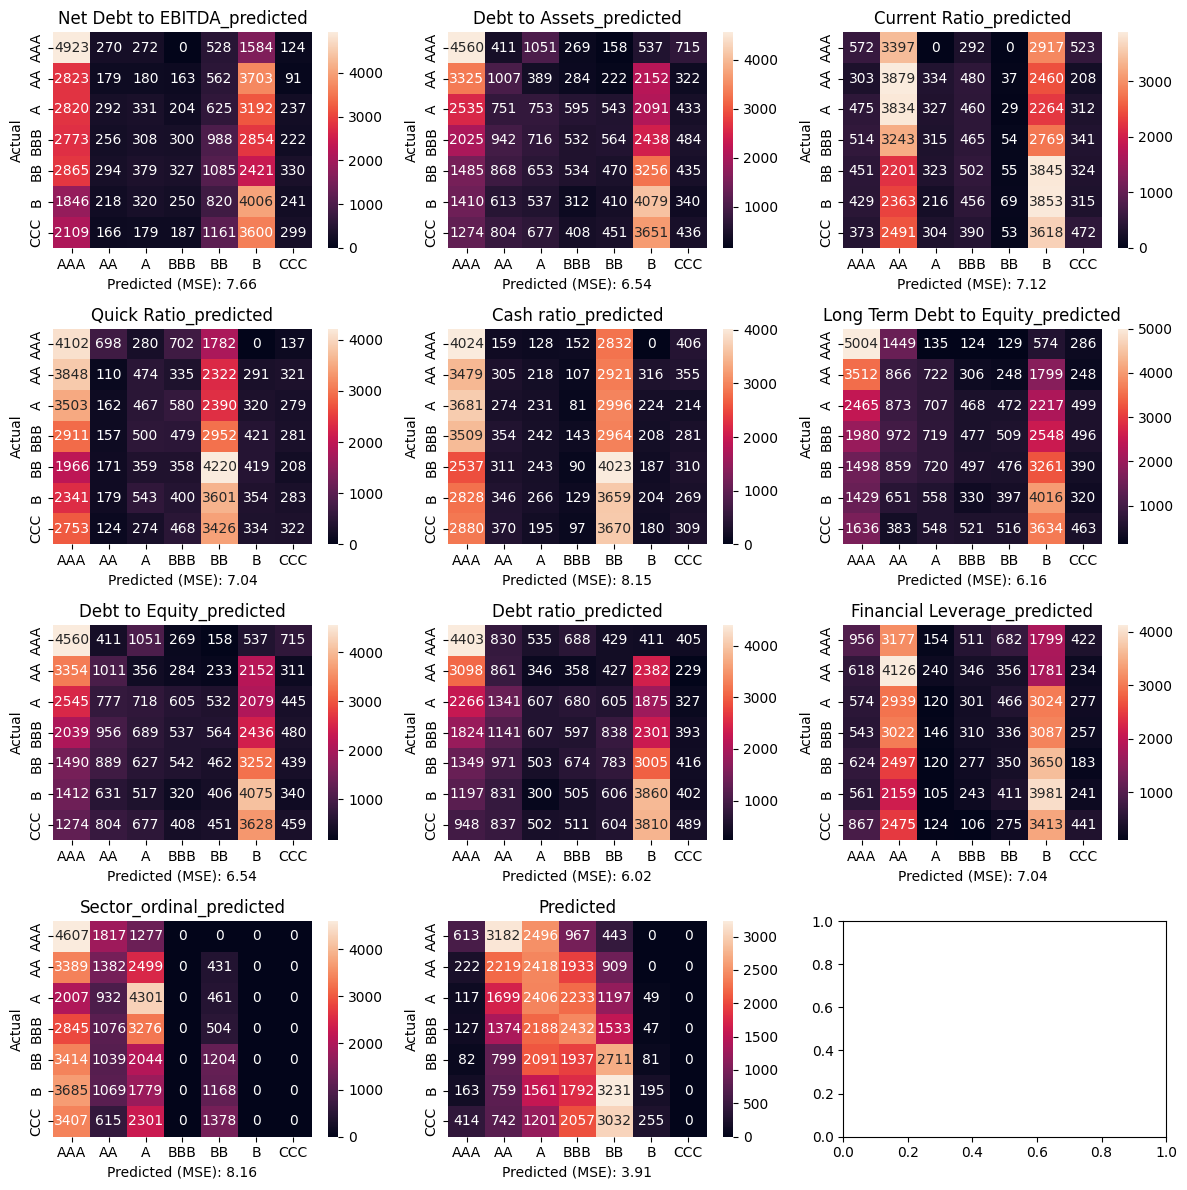

In [16]:
All_rating_order_group = ['AAA','AA','A','BBB','BB','B','CCC']

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for i, var in enumerate([x for x in df_model.columns if 'edicted' in x]):
    row = i // 3
    col = i % 3
    
    y_pred = df_model[var]
    y_true = df_model['Rating_group_ordinal']
    
    cm = confusion_matrix(y_true, y_pred)
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_xticklabels(All_rating_order_group)
    ax.set_yticklabels(All_rating_order_group)
    
    mse = mean_squared_error(y_true, y_pred)
    ax.set_xlabel(f"Predicted (MSE): {np.round(mse,2)}")
    ax.set_ylabel('Actual')
    ax.set_title(var)
    
plt.tight_layout()
plt.show()

Vemos que hemos mejorado bastante usando una combinación de varias pero  tampoco obtenemos ningun resultado bueno, provaremos con diferentes refrsiones

### Modelo de regresion  lineal para todas las varaibels

In [17]:
X = df_model[var_x]  # Tu variable independiente, en este caso la variable 
y = np.array(df_model['Rating_group_ordinal'])  # Tu variable dependiente, ya codificada de 1 a 8 # convert the column 'Rating_group_ordinal' into an array

In [18]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Hacer predicciones
y_pred = model.predict(X_test)

In [21]:
y_pred_rounded = np.round(y_pred, decimals=0)

In [22]:
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

Error Cuadrático Medio (MSE): 3.2328331818638776


Nustro error sigue mejorando

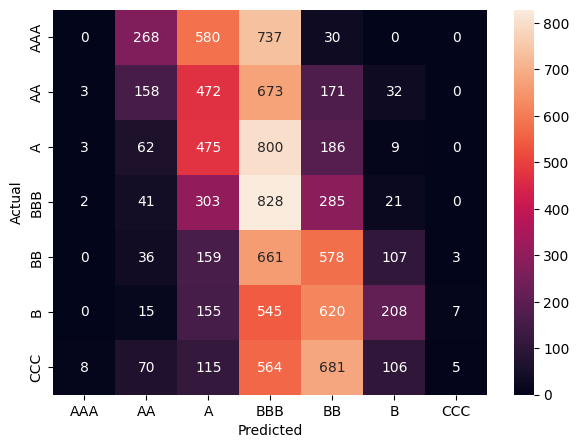

In [23]:
All_rating_order_group = ['AAA','AA','A','BBB','BB','B','CCC']

cm = confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
plt.xticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)
plt.yticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Ahora probaremos con uan regresion multnomial

In [24]:
# Crear un modelo de regresión polinomial
degree = 3  # Grado del polinomio
polyreg_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg_model.fit(X_train, y_train)

y_pred = polyreg_model.predict(X_test)

In [25]:
y_pred_rounded = np.round(y_pred, decimals=0)

In [26]:
# count the number of times that each number appears in the array  
np.unique(y_pred_rounded, return_counts=True) 

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([  15,  206, 1645, 2060, 2824, 2428, 1283,  286,   30,    4,    1],
       dtype=int64))

In [27]:
# make the max between the number less that 0 equal to 0 and the number greater than 6 equal to 6
y_pred_rounded= np.clip(y_pred_rounded, 0, 6)
#y_pred_rounded = np.maximum(y_pred_rounded, 0)
#y_pred_rounded = np.minimum(y_pred_rounded, 6)


In [28]:
mse = mean_squared_error(y_test, y_pred_rounded)
print(f"Error Cuadrático Medio (MSE): {mse}")
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred_rounded == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred_rounded - y_test) <= 1) / len(y_test),4)*100,'%')

Error Cuadrático Medio (MSE): 2.1816917084028935
Number of times it predict the exact number : 25.06 %
Number of times it predict the exact number or 1 different: 70.43 %


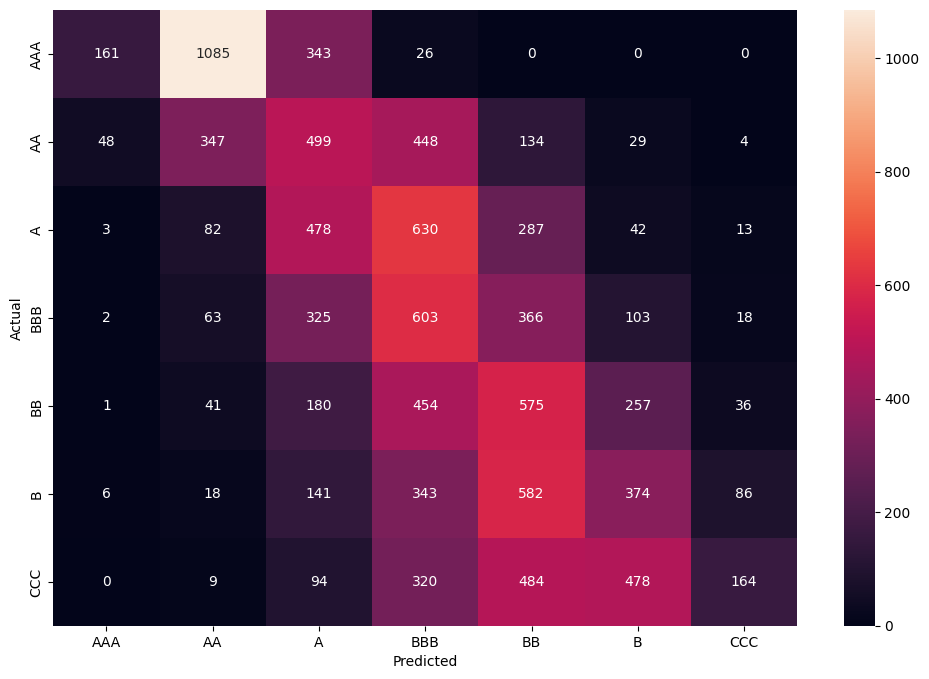

In [29]:
cm = confusion_matrix(y_test, y_pred_rounded)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")
# usa All_rating_order_group como ticks en el eje x e y
plt.xticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)
plt.yticks(ticks=np.arange(7)+0.5, labels=All_rating_order_group)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


El caso de defaul lo hemos quitado porque no es un caso real por ahora lo hemos hecho con los grupos grande.


### Regresion ordianl

Dado que tu variable objetivo, "Rating", es categórica y tiene un orden intrínseco, y estás interesado en predecirla a partir de una serie de variables predictoras tanto numéricas como categóricas, el tipo de regresión más adecuado para tu análisis sería una regresión ordinal.

La regresión ordinal es una variante de regresión lineal que es adecuada para variables dependientes categóricas con un orden claro, como es el caso de tu variable "Rating". A diferencia de la regresión lineal clásica, que asume una variable dependiente continua, o de los modelos de clasificación como la regresión logística, que tratan con categorías sin un orden inherente, la regresión ordinal considera el orden natural entre las categorías de la variable de respuesta.

In [30]:
# Asumiendo que df es tu DataFrame y ya has transformado "sector" a numérica y "Rating" a ordinal
X = df_model[var_x]
y = df_model[var_y]

In [31]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los predictores
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Ajustar el modelo de regresión ordinal
model = mord.LogisticAT(alpha=1.0)  # LogisticAT es uno de los modelos disponibles en mord
model.fit(X_train_scaled, y_train.values)

c:\Users\Ruben\Documents\PhD_AI\Clases\estadistica\rating_analisis\env_ratings\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticAT()

In [33]:
# Hacer predicciones
y_pred = model.predict(X_test_scaled)

In [34]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.429326655537006


In [35]:
y_test = y_test.values.reshape(-1)

In [36]:
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y_test) <= 1) / len(y_test),4)*100,'%')

Error Cuadrático Medio (MSE): 3.3723798924132815
Number of times it predict the exact number : 22.62 %
Number of times it predict the exact number or 1 different: 58.199999999999996 %


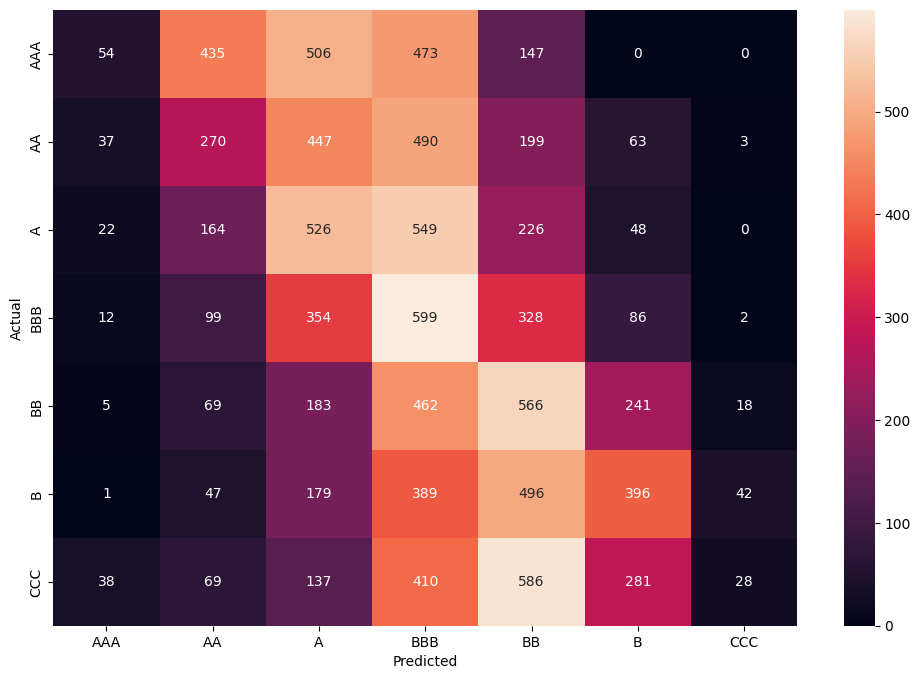

In [37]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")
# change the x and y tick labels by the rating ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'D']
plt.xticks(ticks=[0.5 + i for i in range(7)], labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
plt.yticks(ticks=[0.5 + i for i in range(7)], labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Para este caso obtenemos peores resultaods asi que vemos otras formas
## Modelos de ML
### Random Forest

In [14]:
import pandas as pd
import mord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# read the clean data
df = pd.read_csv('all_data_clean_ordinal_oversampled_group.csv')
print(df.shape)

var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x = var_x_num + ['Sector_ordinal']
var_y = ['Rating_group_ordinal']
df = df[var_y + var_x]

df_model = df[df['Rating_group_ordinal'] != 7] # quitamos el raintg C que es el grupo 7
del df
df_model

(61608, 28)


,Rating_group_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,0,3.984227,0.450358,0.505683,0.260870,0.023160,0.438347,0.819365,2.999334,2.457548,3
1,0,0.976955,0.346605,0.990896,0.482563,0.230977,0.350060,0.530467,4.599136,2.439691,6
2,0,1.973726,0.169415,0.036487,0.034469,0.000000,0.000000,0.203971,5.946242,1.212861,7
3,0,4.427664,0.633197,0.733832,0.712113,0.535803,1.287241,1.726263,2.184500,3.771021,3
4,0,1.096102,0.231896,0.992748,0.586221,0.337389,0.262156,0.301907,6.984434,2.108649,3
...,...,...,...,...,...,...,...,...,...,...,...
53902,6,0.814066,0.428193,1.668137,1.182205,0.580163,0.525848,0.748843,2.853482,2.136809,1
53903,6,2.110658,0.478092,0.949762,0.941875,0.650448,0.826536,0.916046,2.503983,2.293764,3
53904,6,4.929733,0.425980,1.519325,0.905881,0.267209,0.702506,0.742099,2.882532,2.139124,1
53905,6,8.452607,0.420066,1.288832,0.749679,0.438383,0.614159,0.724333,2.614302,1.893625,1


In [3]:
X = df_model[var_x]  # Tu variable independiente, en este caso la variable 
y = np.array(df_model['Rating_group_ordinal'])  # Tu variable dependiente, ya codificada de 1 a 8 # convert the column 'Rating_group_ordinal' into an array

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators es el número de árboles
# Entrena el modelo
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")
#count the number of times the prediction value is equal to the real value over the total number of predictions
print('Number of times it predict the exact number :',np.round(np.sum(y_pred == y_test) / len(y_test),4)*100,'%')

# count the number of times the prediction value is equal o have only 1 different to the real value over the total number of predictions
print('Number of times it predict the exact number or 1 different:',np.round(np.sum(abs(y_pred - y_test) <= 1) / len(y_test),4)*100,'%')

# Calcular la precisión en ambos conjuntos
y_train_pred = rf_model.predict(X_train)
# Predicciones en el conjunto de prueba
y_test_pred = rf_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Precisión en el conjunto de entrenamiento: {train_accuracy}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

Error Cuadrático Medio (MSE): 0.1010016694490818
Number of times it predict the exact number : 94.57 %
Number of times it predict the exact number or 1 different: 98.7 %
Precisión en el conjunto de entrenamiento: 1.0
Precisión en el conjunto de prueba: 0.9457429048414023


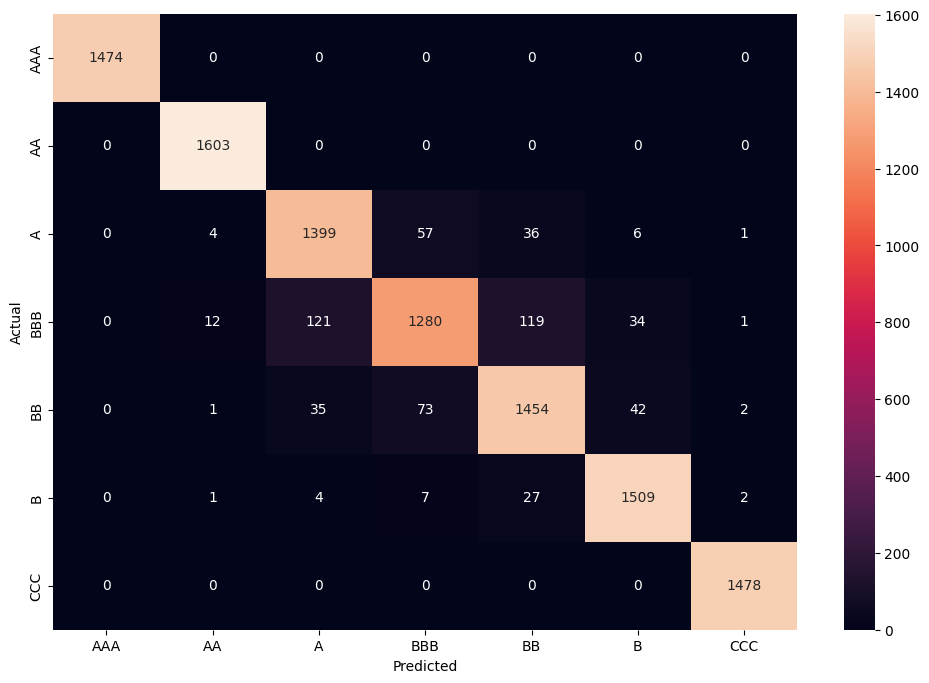

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")
# change the x and y tick labels by the rating ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'D']
plt.xticks(ticks=[0.5 + i for i in range(7)], labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
plt.yticks(ticks=[0.5 + i for i in range(7)], labels=['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


XXX
1) descargasr los datos del S&P e IBEX, ver si estan en el modelo y clasificar esas compaññias a dia de hoy
2) reducir el numbero de arboles del random forest
3) hacer con el algoritmo de random forest
4) mirar las XXX de todo el codigo
5) limpiar el codigo, y mandar correo al profresor
6) escribir el articulo

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X=X.values,
    y=y.values,
    train_sizes=np.linspace(0.01, 1.0, 50),
    cv=5,
    n_jobs=-1,
    scoring='accuracy')

# Calcular medias y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Graficar las curvas
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

Poder usar este modelo desde excel (sacar los datos y la caslficaicon de las industrias y los rating)

Estos supuestos pueden ser también expresados de forma equivalente en términos de u.
1) El valor esperado de la perturbación aleatoria es cero E(u)=0. XXX ver
2) La varianza del término error es constante para todos los valores de la variable independiente X (homocedasticidad). XXX ver
3) No hay autocorrelación.  (OK)
4) El error está normalmente distribuido. XXX ver
